# CW 02

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import misc
from PIL import Image

In [200]:
array_size = 300e-6  
num_pixels = 512  # Resolution

dx = array_size / num_pixels  # Pixel size

wvl = 633e-9
dz = 30e-6


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

# Q1

Build a wave propagation function that calculates the output field by iteratively propagating wave a "d_z" distance in a for loop with angular spectrum method. After each propagation step apply the absorptive boundary to avoid wraparound.

In [201]:
def angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)
        
    return U_list


# Q2
Propagate the provided image to 300 um and backpropagate

C:\Users\ilker\AppData\Local\Temp\ipykernel_92492\2839698563.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  cameraman_image = misc.face(gray=True)


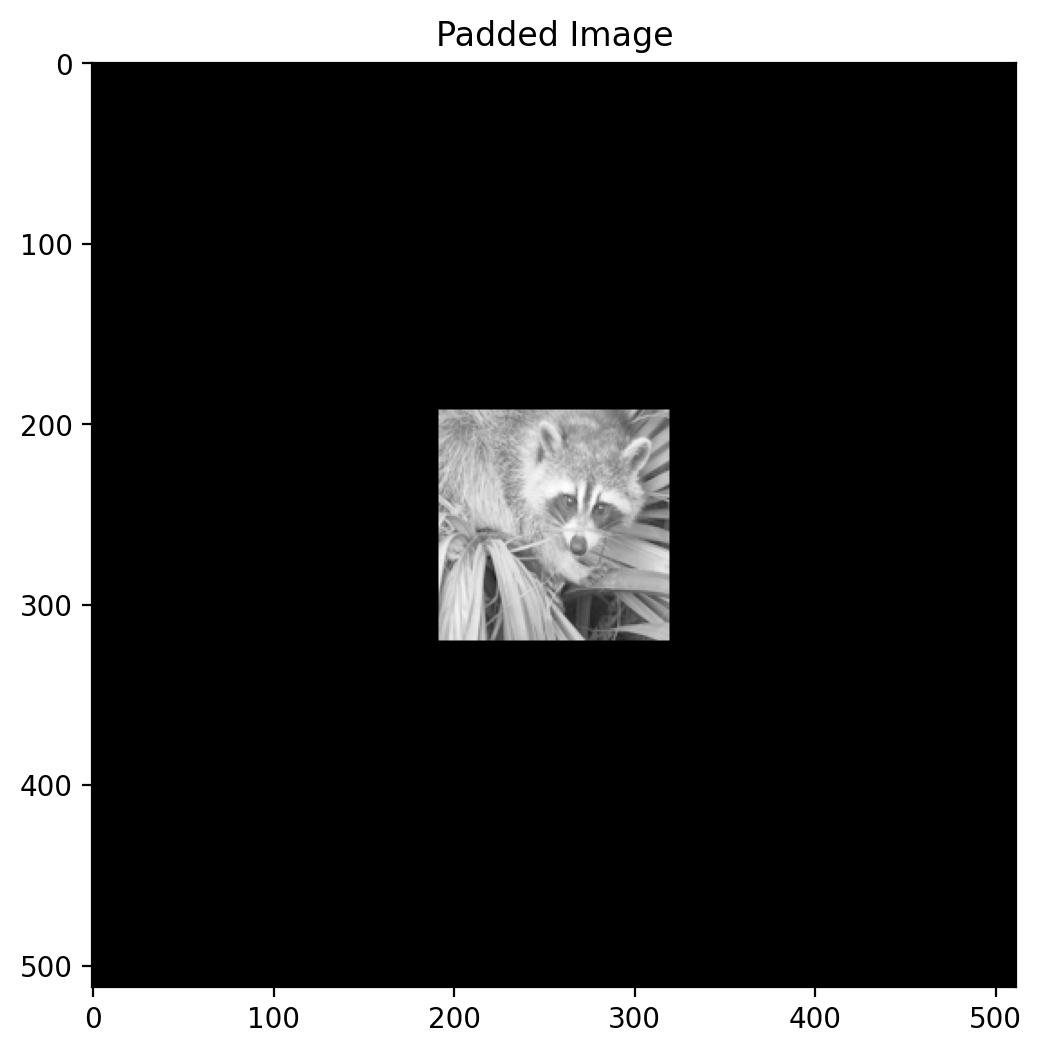

In [202]:


# Load the cameraman image
cameraman_image = misc.face(gray=True)
# Resize the image to nx/4 resolution
cameraman_image_pil = Image.fromarray(cameraman_image)
resized_image_pil = cameraman_image_pil.resize((num_pixels // 4, num_pixels // 4))
resized_image = np.sqrt(np.array(resized_image_pil)/255.0)

# Pad the image to nx resolution
padded_image = np.pad(resized_image, 
                      (((num_pixels - resized_image.shape[0]) // 2,), 
                       ((num_pixels - resized_image.shape[1]) // 2,)), 
                      mode='constant')

plt.figure(figsize=(6, 6),dpi = 200)
plt.imshow(padded_image, cmap="gray")
plt.title("Padded Image")
plt.show()

In [210]:
prop_distance = 3e-4
prop_steps = np.round(prop_distance / dz).astype(int)
grating_zs = angular_spectrum_propagation_range(padded_image, wvl, dx, dz, prop_steps, True)

array_3d = np.stack(grating_zs, axis=0)

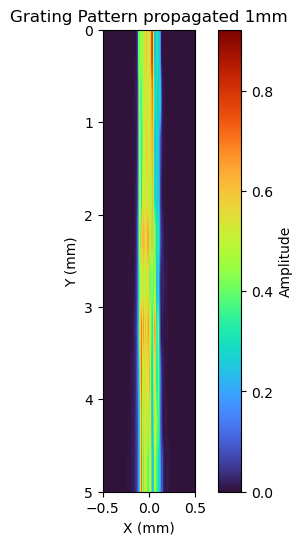

In [211]:
# Display the grating
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(array_3d[:, 256, :])**2, cmap="turbo", extent=[-0.5, 0.5, 5, 0])
plt.colorbar(label="Amplitude")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

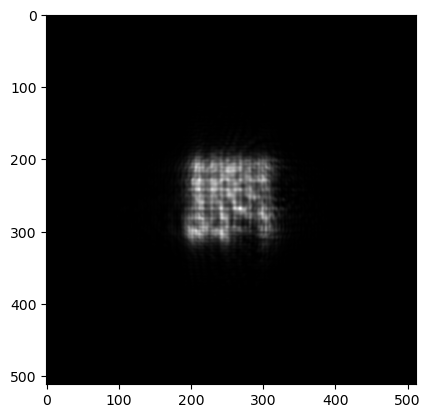

In [212]:
plt.imshow(np.abs(array_3d[-1, :, :])**2, cmap="gray")


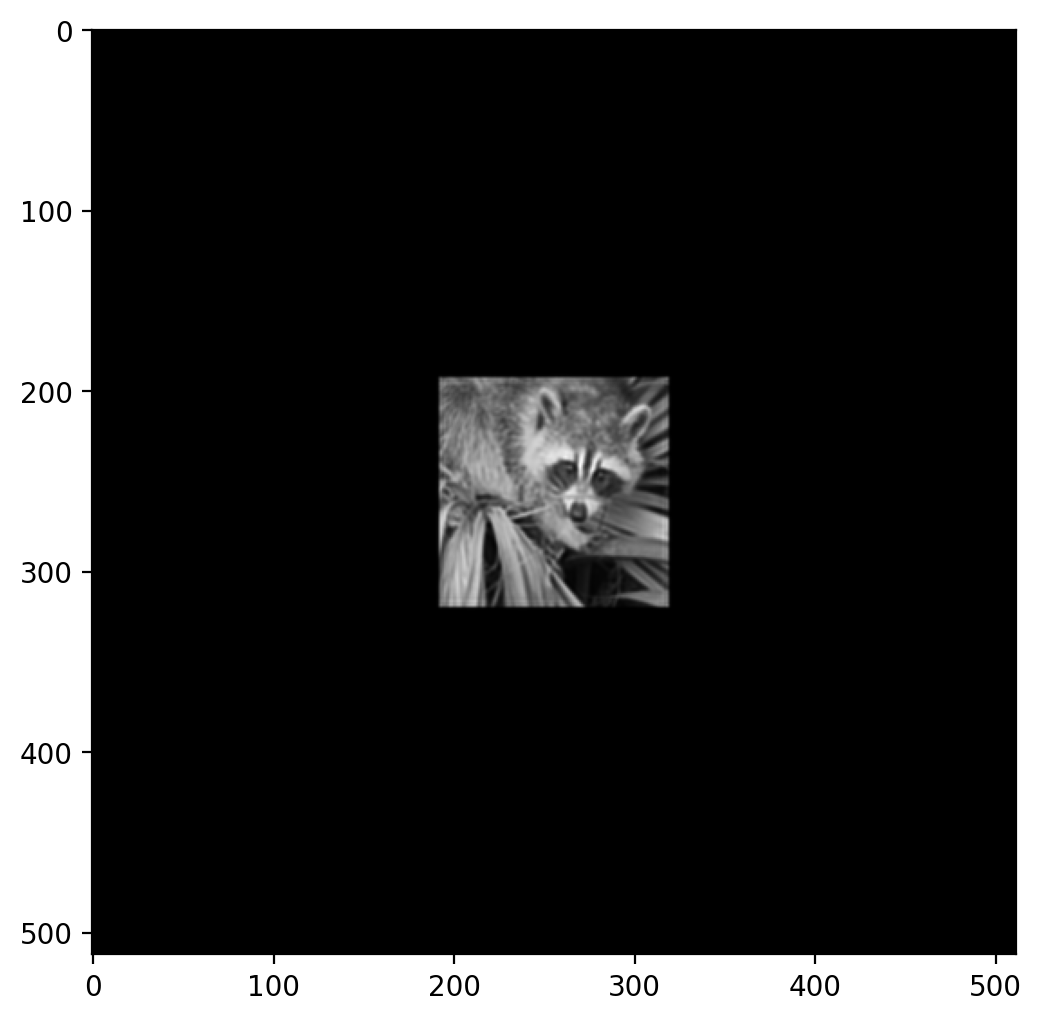

In [213]:
grating_zs = angular_spectrum_propagation_range(array_3d[-1, :, :], wvl, dx, -dz, prop_steps, True)
array_3d = np.stack(grating_zs, axis=0)
plt.figure(figsize=(6, 6),dpi = 200)
plt.imshow(np.abs(array_3d[-1, :, :])**2, cmap="gray")

# Q3
Propagate the provided image to 1 mm and backpropagate